# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [12]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [13]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [14]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 2
PCA Explained variance: [443782.6051466    7310.10006165]
Classes:[0 1]; Encoded as: [-1  1]


In [15]:
surface0_exp = pd.read_csv('Logs-Cancer-v4/m0_exp/LossFunctionSurface.csv', index_col=0)
path0_exp = pd.read_csv('Logs-Cancer-v4/m0_exp/m0_exp-0-Weights.csv', index_col=0)
path0_exp[path0_exp.shape[1]] = pd.read_csv('Logs-Cancer-v4/m0_exp/m0_exp-0-LossFunction.csv', index_col=0)
# Drop column names so we can concat()...
surface0_exp = surface0_exp.transpose().reset_index(drop=True).transpose()
path_m0_exp = path0_exp.transpose().reset_index(drop=True).transpose()

surface0 = pd.read_csv('Logs-Cancer-v4/m0/LossFunctionSurface.csv', index_col=0)
path0 = pd.read_csv('Logs-Cancer-v4/m0/m0-0-Weights.csv', index_col=0)
path0[path0.shape[1]] = pd.read_csv('Logs-Cancer-v4/m0/m0-0-LossFunction.csv', index_col=0)
# Drop column names so we can concat()...
surface0 = surface0.transpose().reset_index(drop=True).transpose()
path0 = path0.transpose().reset_index(drop=True).transpose()

surface1 = pd.read_csv('Logs-Cancer-v4/m1/LossFunctionSurface.csv', index_col=0)
path1 = pd.read_csv('Logs-Cancer-v4/m1/m1-1-Weights.csv', index_col=0)
path1[path1.shape[1]] = pd.read_csv('Logs-Cancer-v4/m1/m1-1-LossFunction.csv', index_col=0)
surface1 = surface1.transpose().reset_index(drop=True).transpose()
path1 = path1.transpose().reset_index(drop=True).transpose()

surface2 = pd.read_csv('Logs-Cancer-v4/m2/LossFunctionSurface.csv', index_col=0)
path2 = pd.read_csv('Logs-Cancer-v4/m2/m2-0-Weights.csv', index_col=0)
path2[path2.shape[1]] = pd.read_csv('Logs-Cancer-v4/m2/m2-0-LossFunction.csv', index_col=0)
surface2 = surface2.transpose().reset_index(drop=True).transpose()
path2 = path2.transpose().reset_index(drop=True).transpose()

surface3 = pd.read_csv('Logs-Cancer-v4/m3/LossFunctionSurface.csv', index_col=0)
path3 = pd.read_csv('Logs-Cancer-v4/m3/m3-3-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv('Logs-Cancer-v4/m3/m3-3-LossFunction.csv', index_col=0)
surface3 = surface3.transpose().reset_index(drop=True).transpose()
path3 = path3.transpose().reset_index(drop=True).transpose()

In [16]:
from sklearn.decomposition import PCA

def plotSurface(surface:pd.DataFrame, path=None, title = '', save:str = None, dpi = 80, pcs=(0, 1), pc_max=2, plot_path=True):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]
    pca = PCA(n_components=pc_max)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(parameters)
    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    
    principalSurfaceDataDF = pd.DataFrame()
    principalSurfaceDataDF['x'] = principalSurfaceData[:, pcs[0]]
    principalSurfaceDataDF['y'] = principalSurfaceData[:, pcs[1]]
    principalSurfaceDataDF['z'] = zValue
    
    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x']
    surfaceYs = principalSurfaceDataDF['y']
    surfaceZs = principalSurfaceDataDF['z']
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlabel(f'Params PC{pcs[0]+1}')
    ax.set_ylabel(f'Params PC{pcs[1]+1}')
    ax.set_zlabel('Means Absolute Error')
    ax.set_title(title)
    
    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow_r'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.5)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None and plot_path:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]
        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame()
        principalPathDataDF['x'] = principalPathData[:, pcs[0]]
        principalPathDataDF['y'] = principalPathData[:, pcs[1]]
        principalPathDataDF['z'] = pathZvalue
        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                color='red',
                linewidth=3,
                antialiased=False,
                alpha=1)

    plt.show()

    if save:
        plt.savefig(save)


Explained Variance Ratio: [0.51956201 0.48043799]


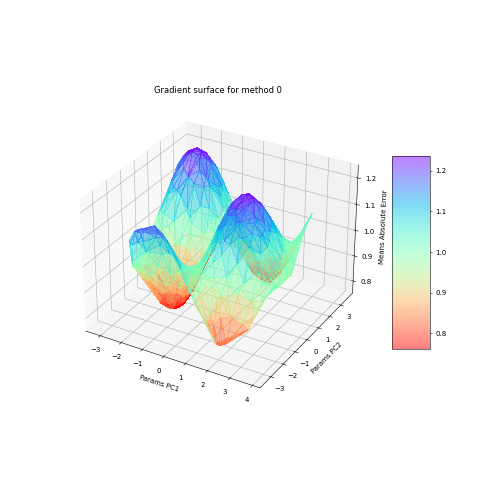

In [17]:
%matplotlib widget
plotSurface(surface0_exp, path=path_m0_exp, title='Gradient surface for method 0', dpi=50, save='m0.png')

Explained Variance Ratio: [0.02795481 0.02705615]


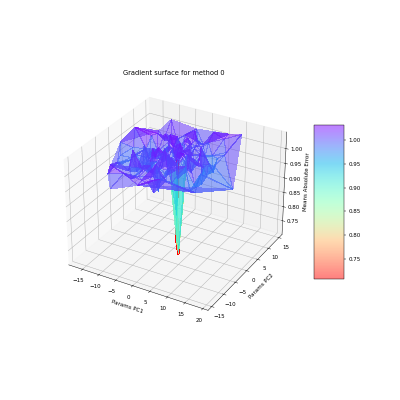

In [18]:
%matplotlib widget
plotSurface(surface0, path=path0, title='Gradient surface for method 0', dpi=40, save='m0.png')

Explained Variance Ratio: [0.07685873 0.07126131]


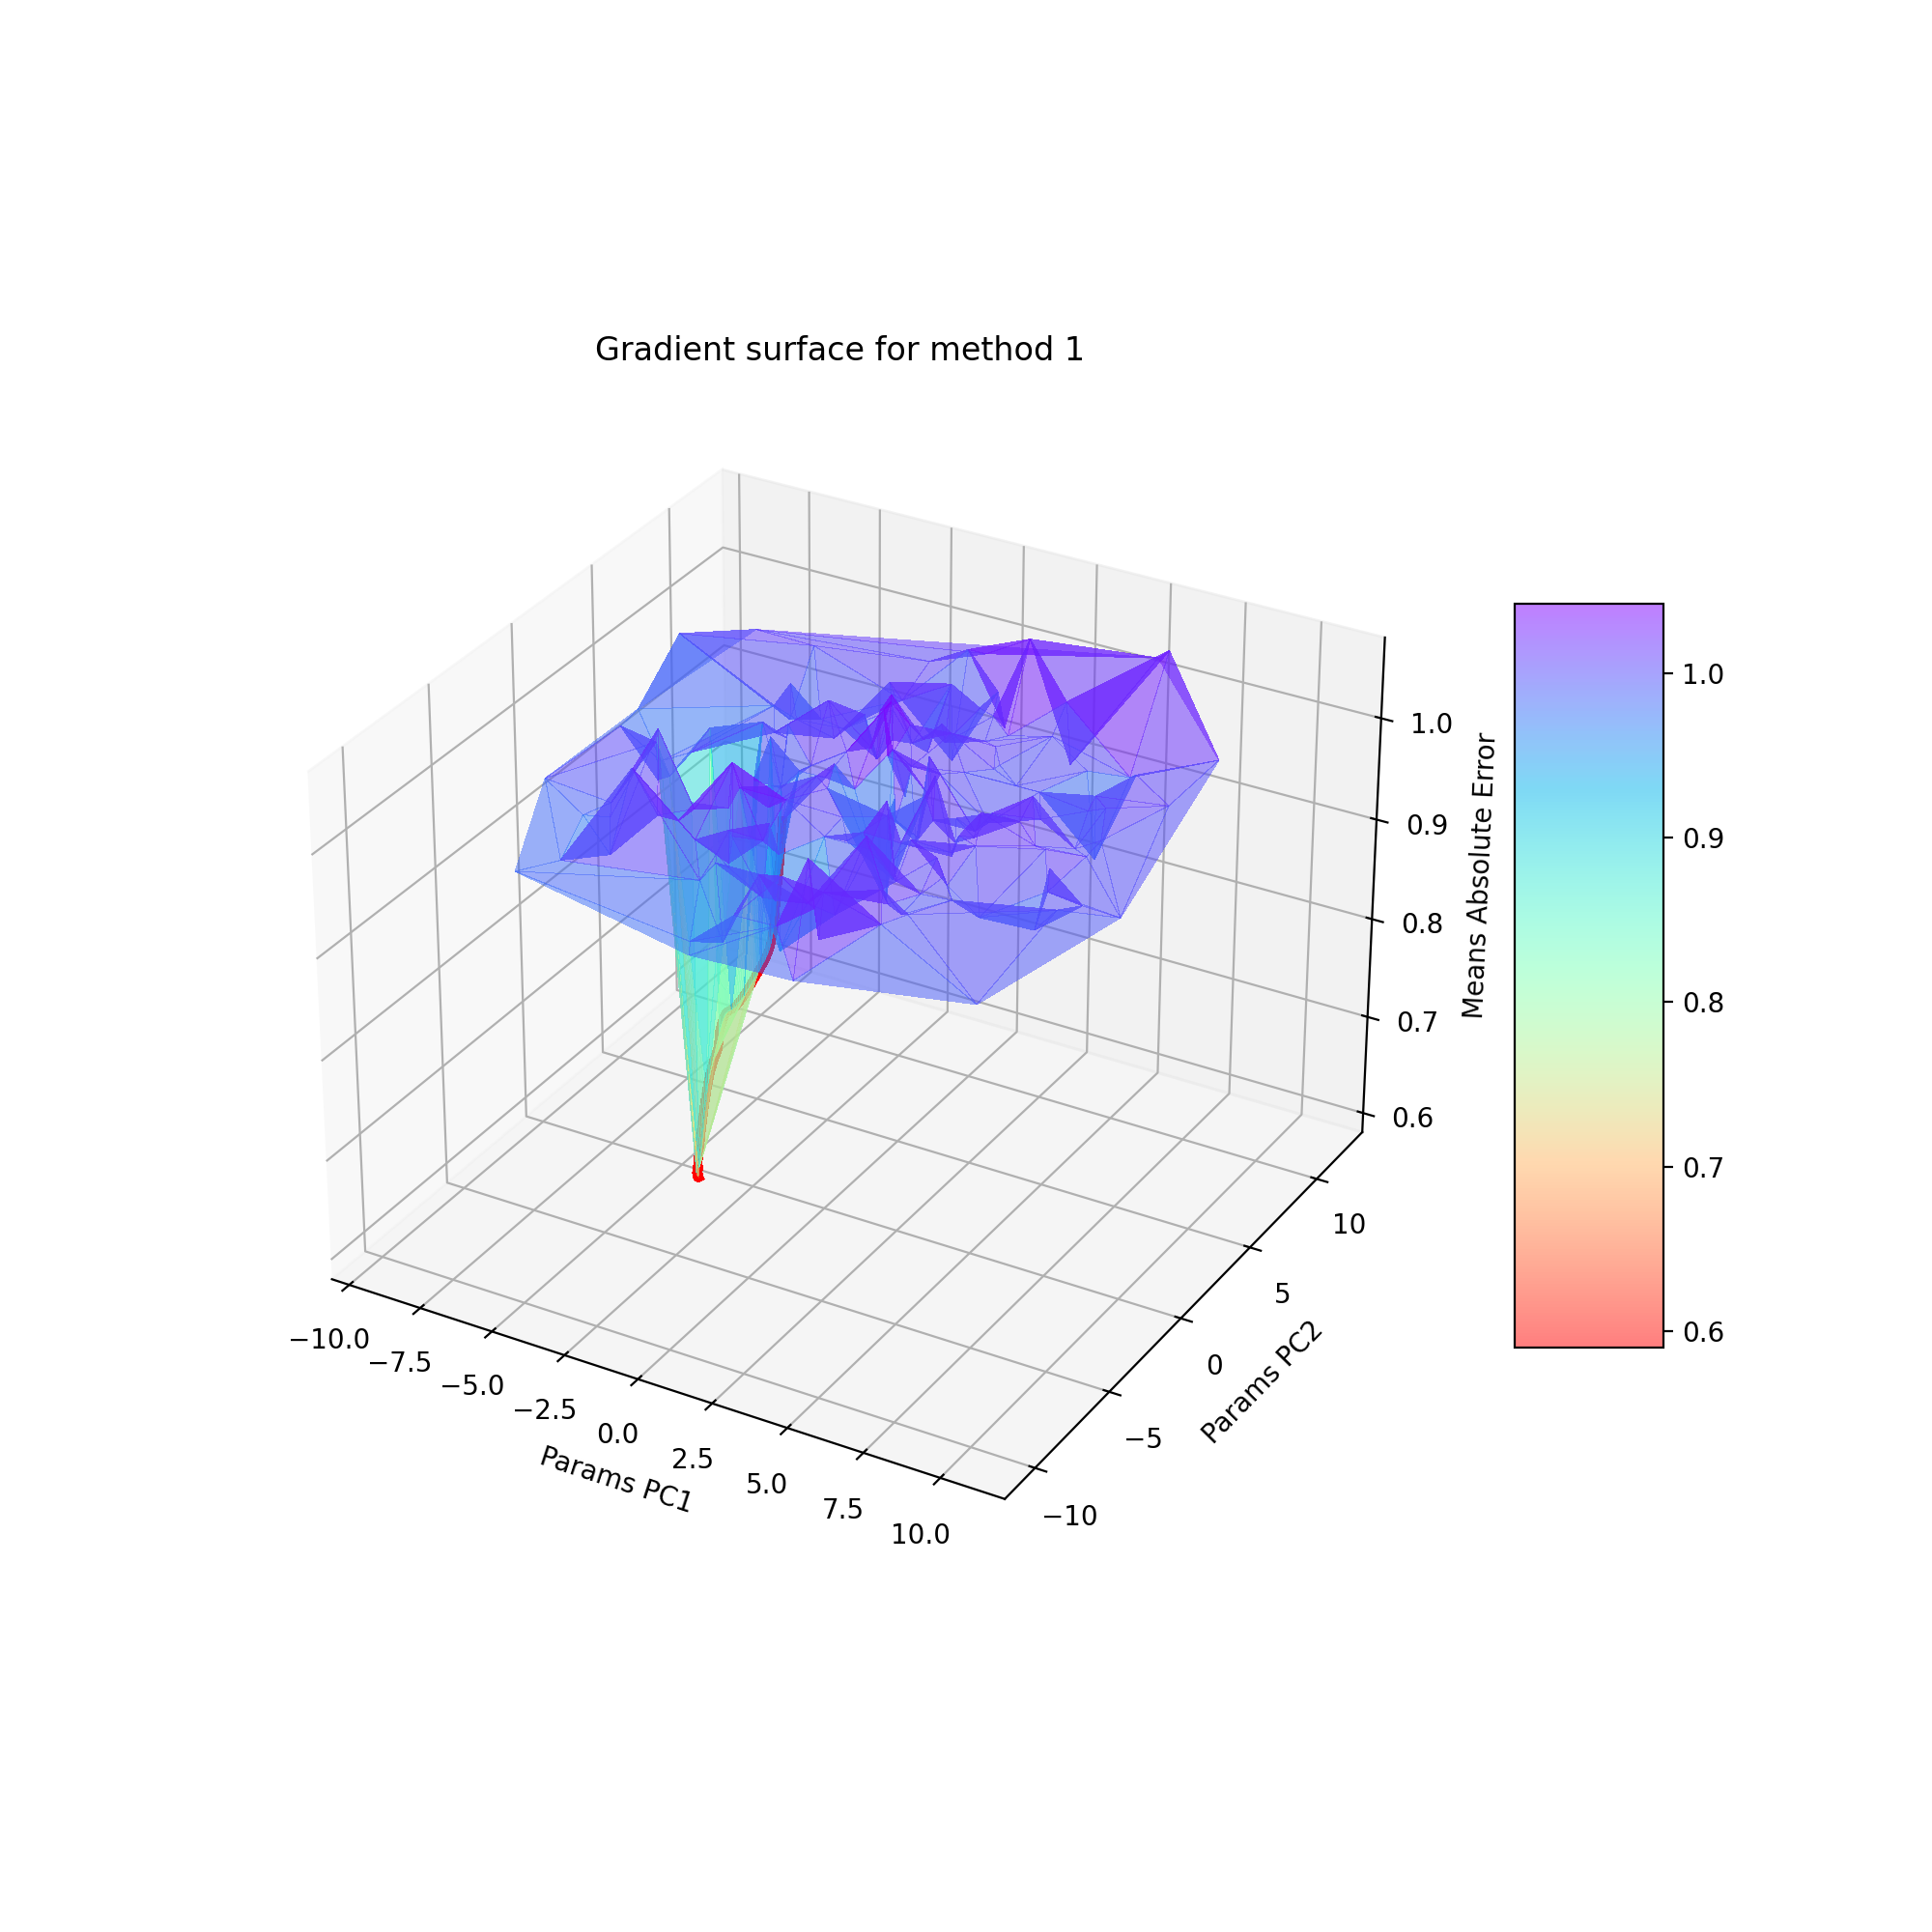

In [19]:
%matplotlib widget
plotSurface(surface1, path=path1, title='Gradient surface for method 1', dpi=200, save='m1.png')

Explained Variance Ratio: [0.02838927 0.02629587]


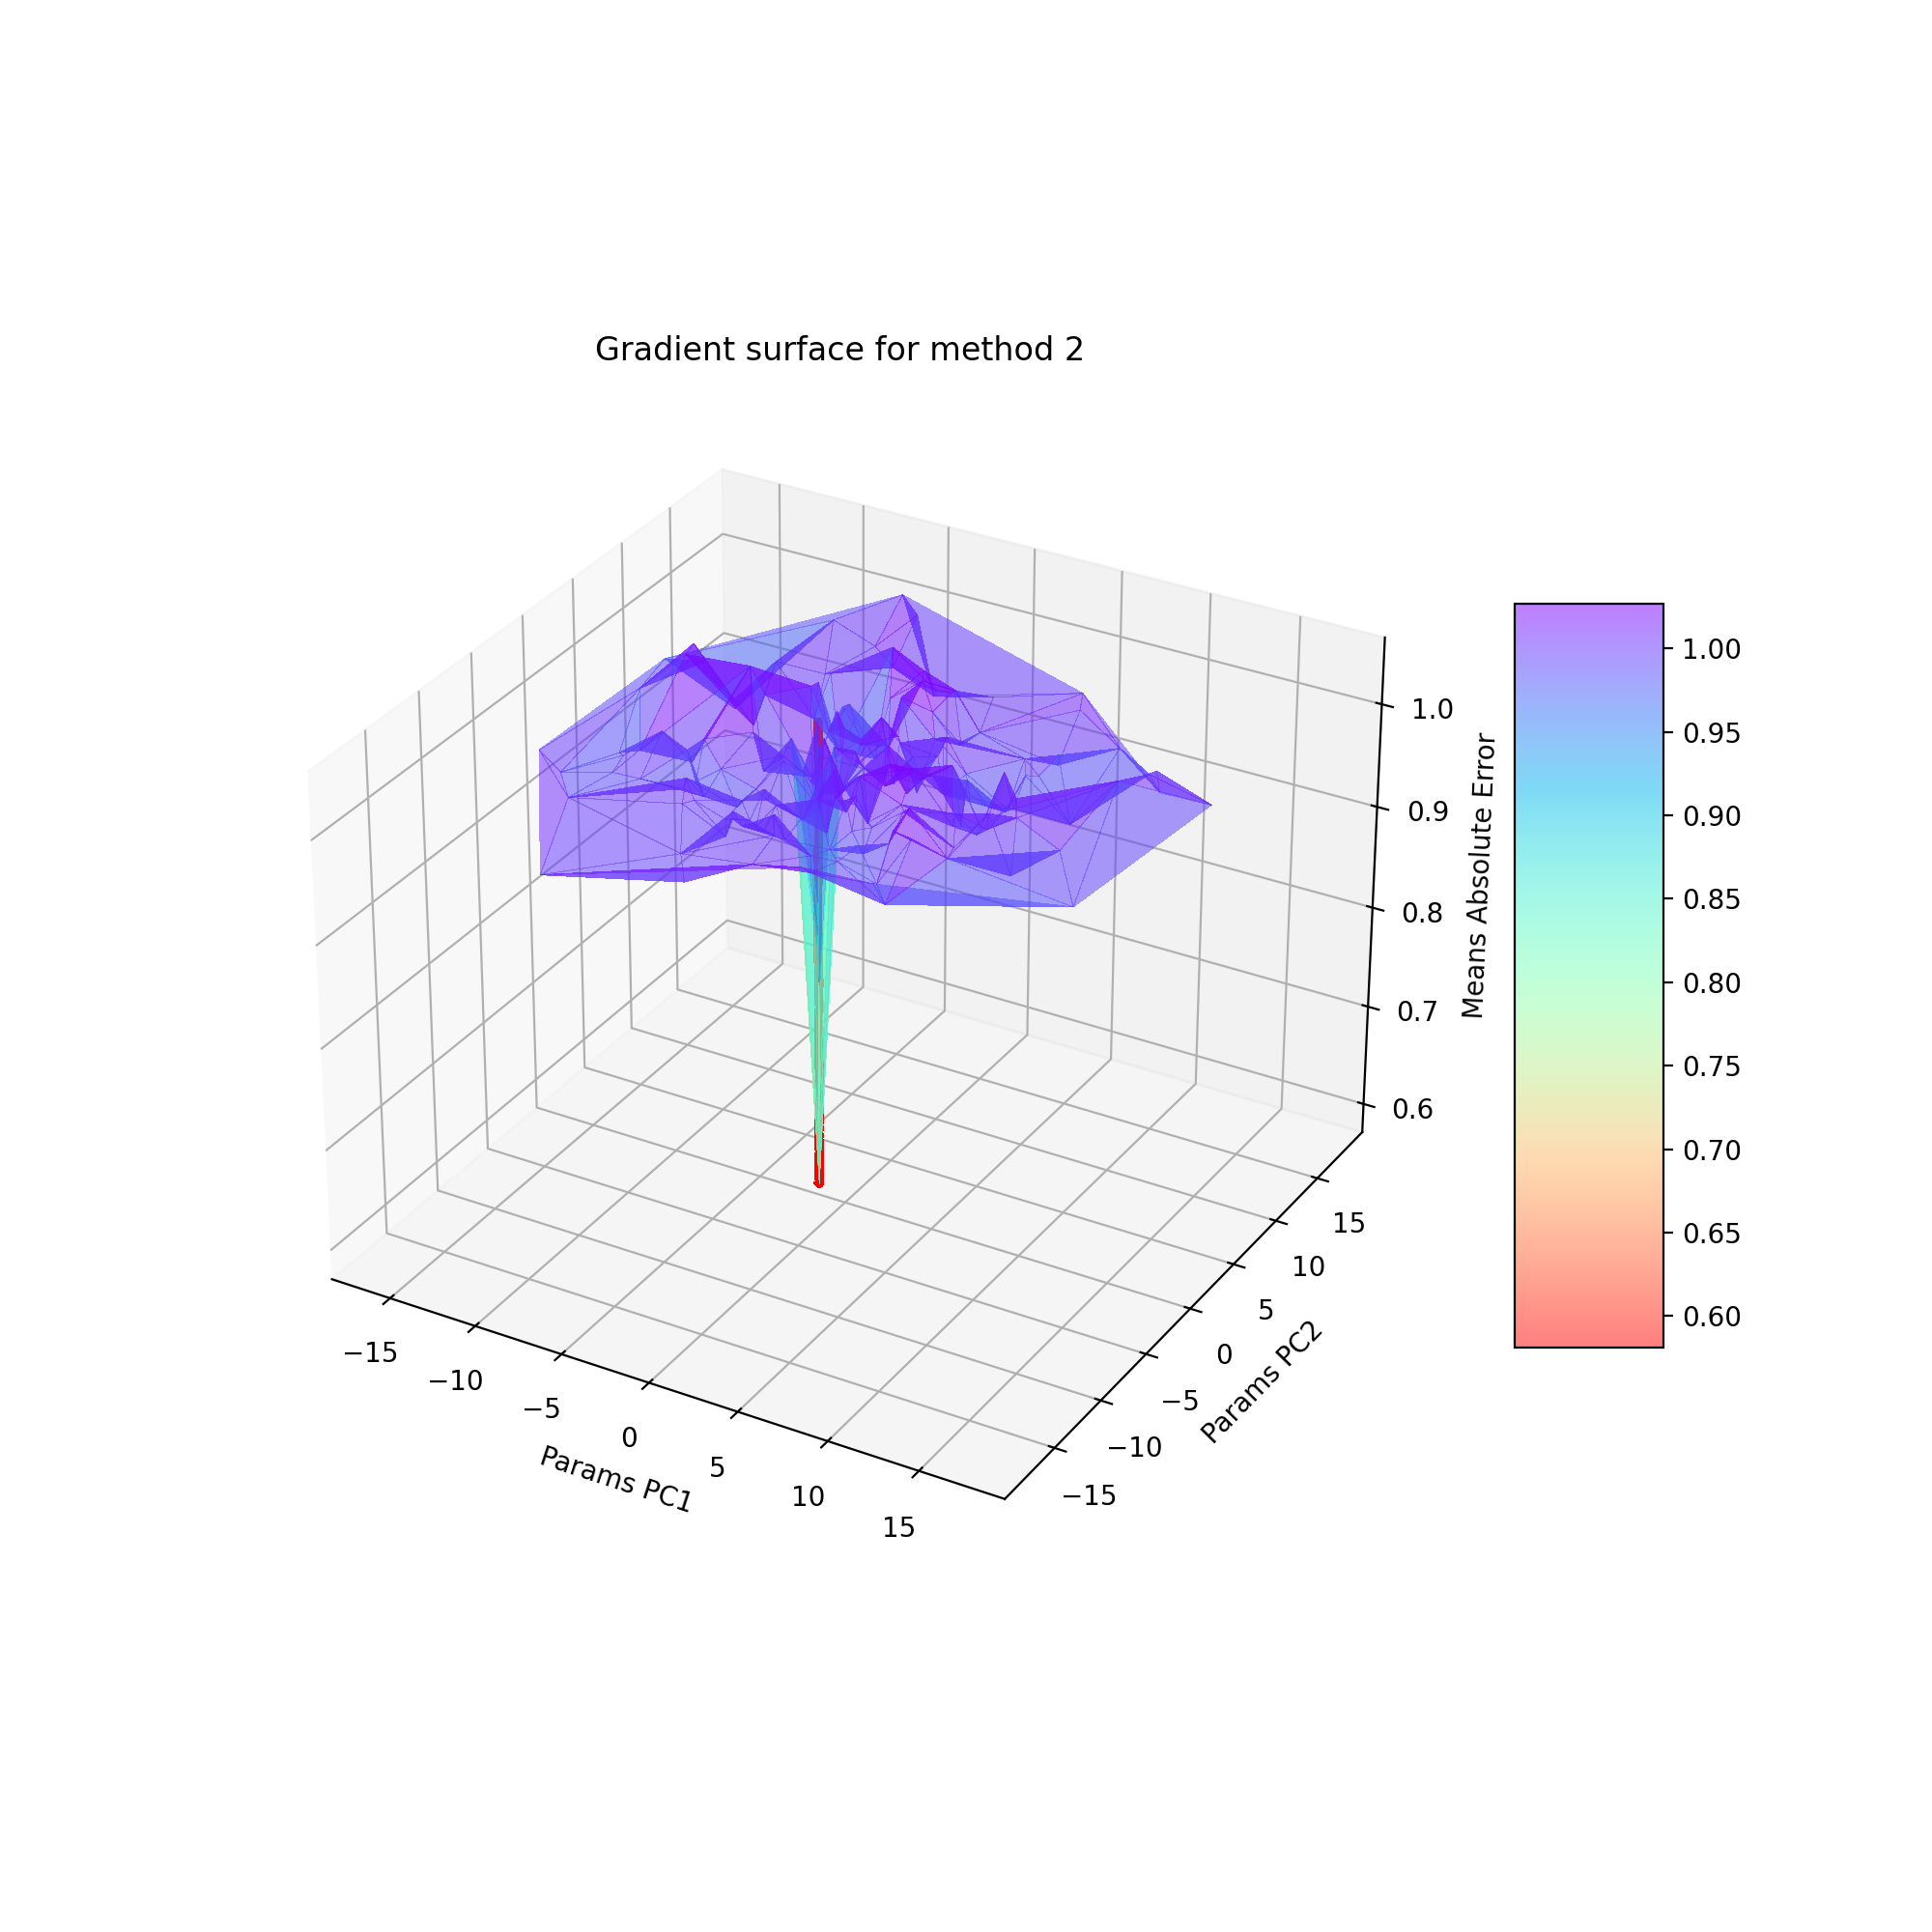

In [20]:
%matplotlib widget
plotSurface(surface2, path=path2, title='Gradient surface for method 2', dpi=200, save='m2.png')

Explained Variance Ratio: [0.23550141 0.01935466 0.0185331  0.01830614 0.01758889 0.01728238
 0.01661403 0.01605047 0.01589172 0.0155811 ]


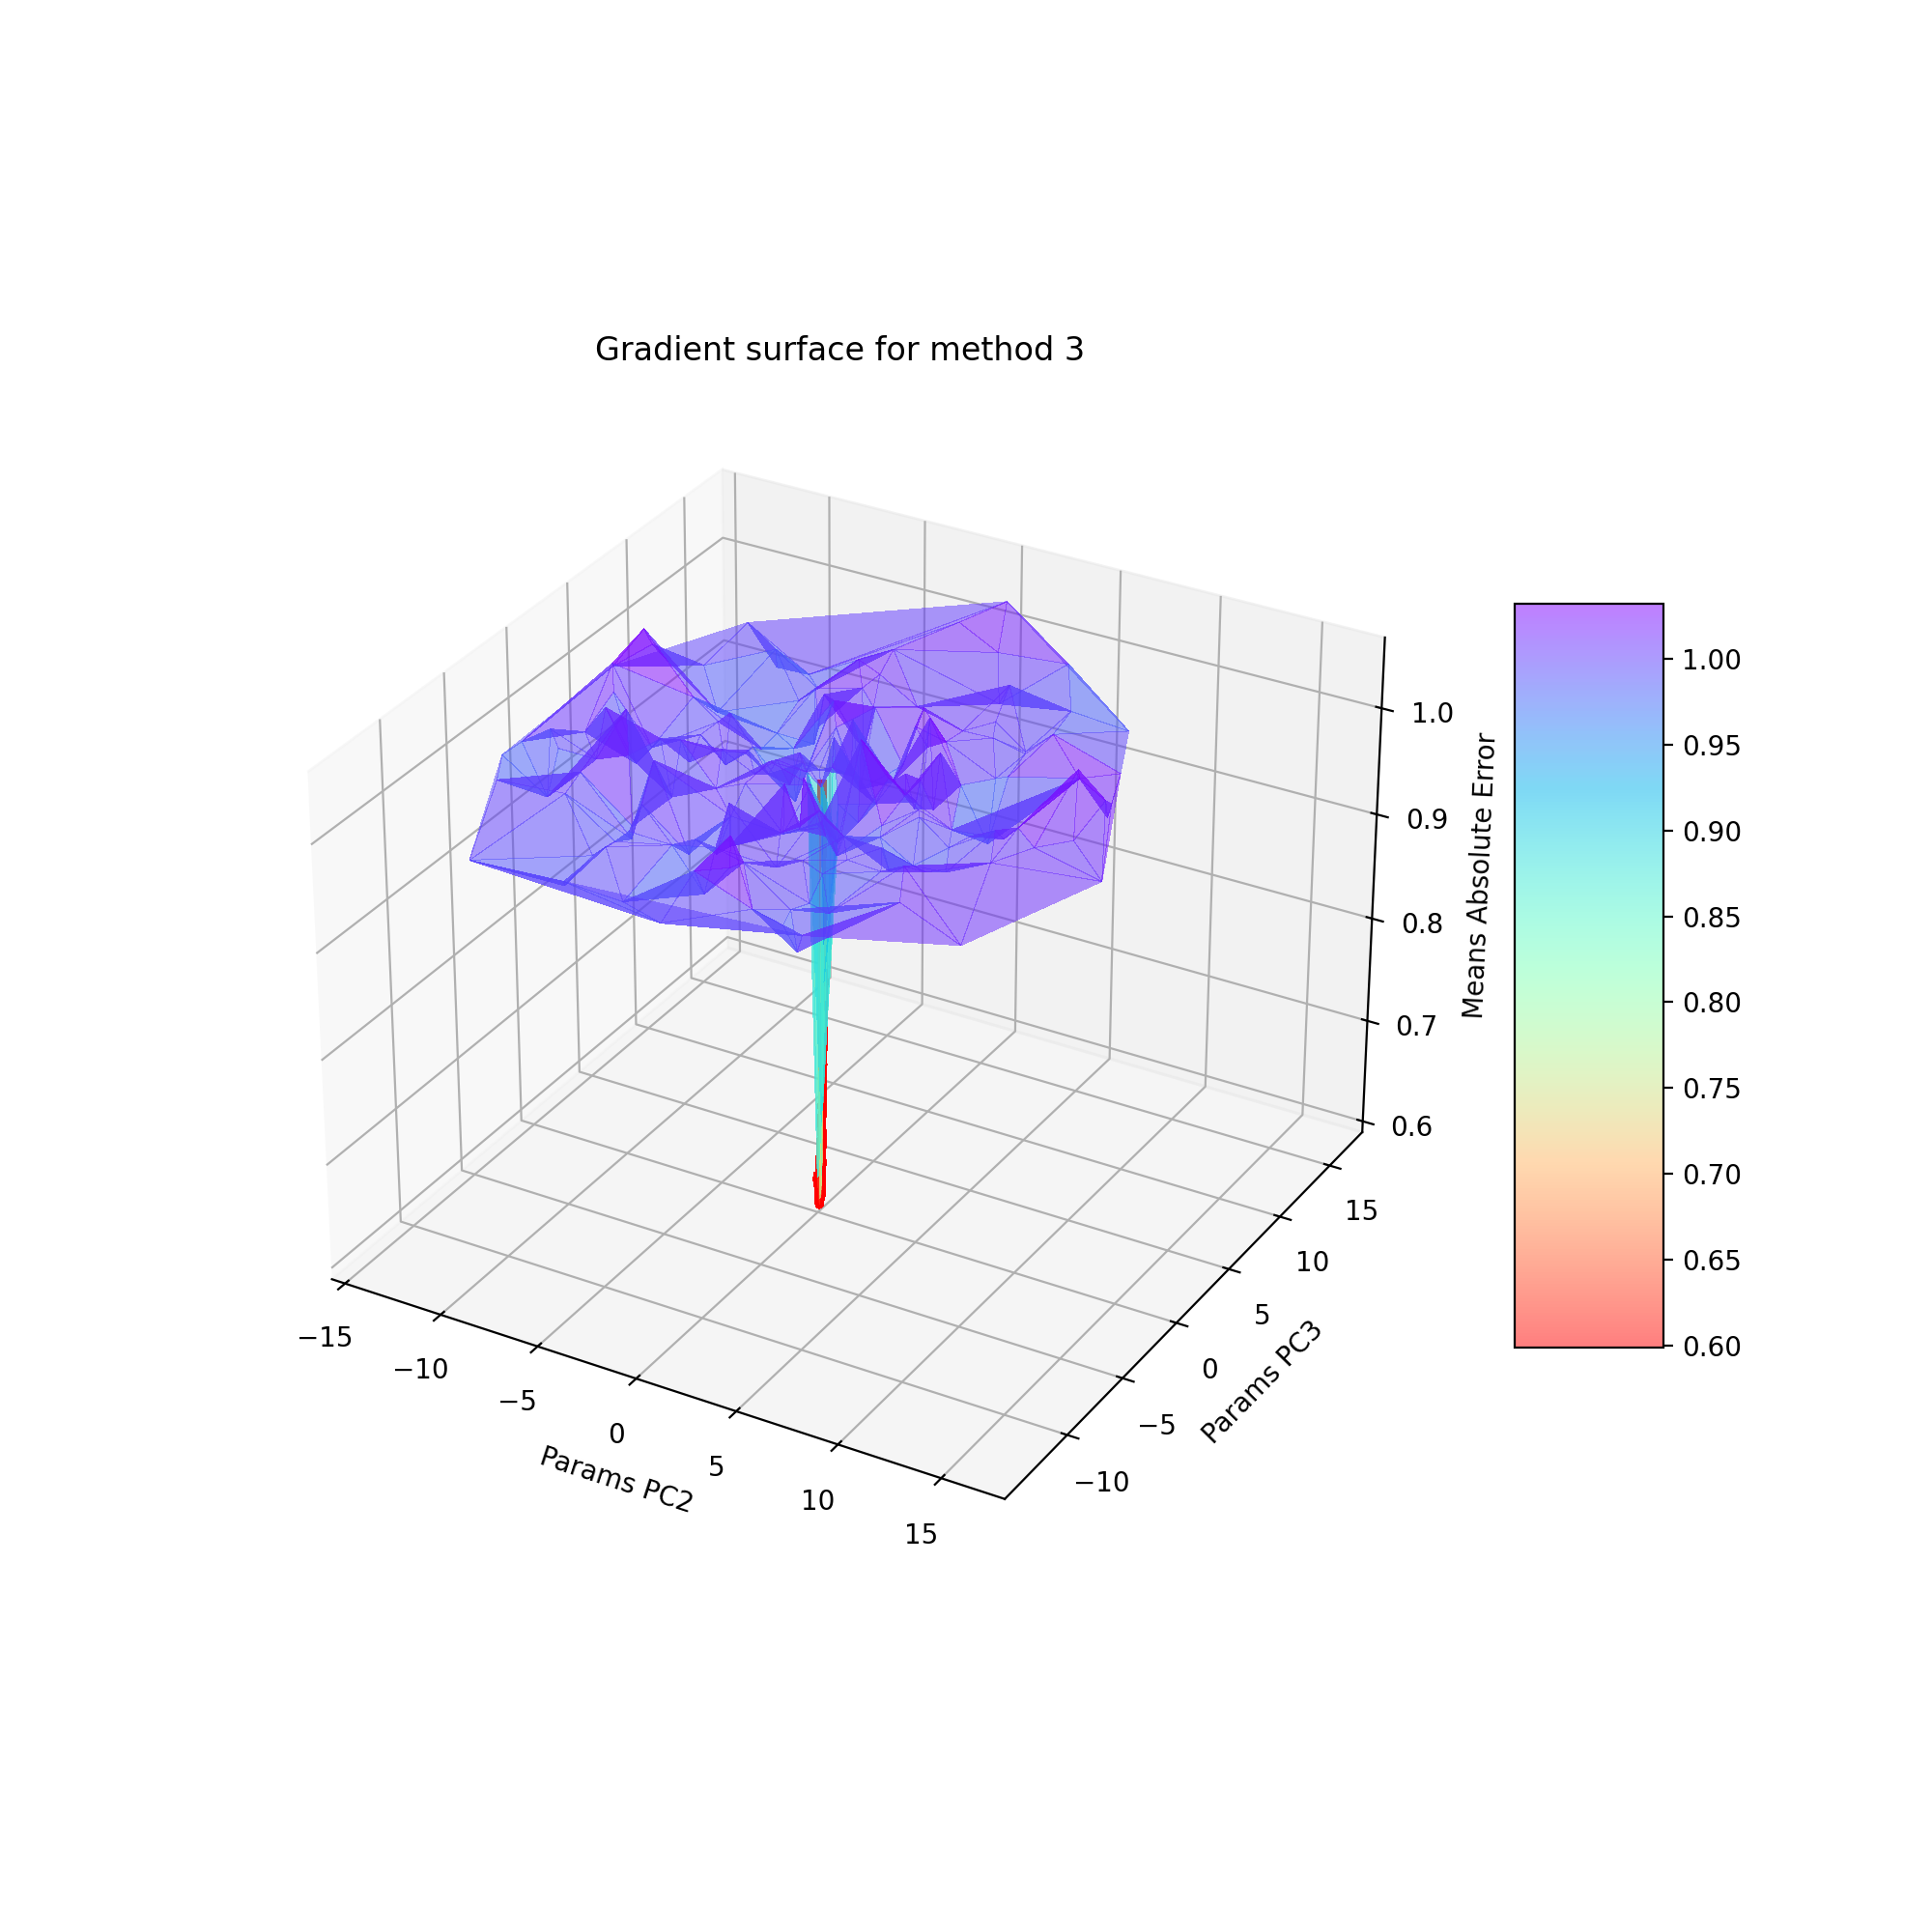

In [21]:
%matplotlib widget
plotSurface(surface3, path=path3, title='Gradient surface for method 3', dpi=200, save='m3.png', pc_max=10, pcs=(1, 2))

In [22]:
!pip list | grep -e qiskit -e torch

qiskit                    0.45.2
qiskit-aer                0.13.2
qiskit-algorithms         0.2.2
qiskit-ibm-provider       0.8.0
qiskit-ibm-runtime        0.18.0
qiskit-machine-learning   0.7.1
qiskit_qulacs             0.0.1
qiskit-terra              0.45.2
torch                     1.11.0
torchsummary              1.5.1
torchvision               0.14.1

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
